# install pytorch
! pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116

# install detectron
! pip install 'git+https://github.com/facebookresearch/detectron2.git'

# install other packages
! pip install opencv-python

In [1]:
import torch
print(torch.__version__)

1.13.1+cu116


In [2]:
# import neccessary libararies
import numpy as np 
import pdb 
import os, json, cv2

import detectron2
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer


In [3]:
# register the dataset
detectron2.data.datasets.register_coco_instances(
        "hagrid_train", {}, './hagrid_coco_format/train.json', '.'
    )

detectron2.data.datasets.register_coco_instances(
        "hagrid_test", {}, './hagrid_coco_format/test.json', '.'
    )


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



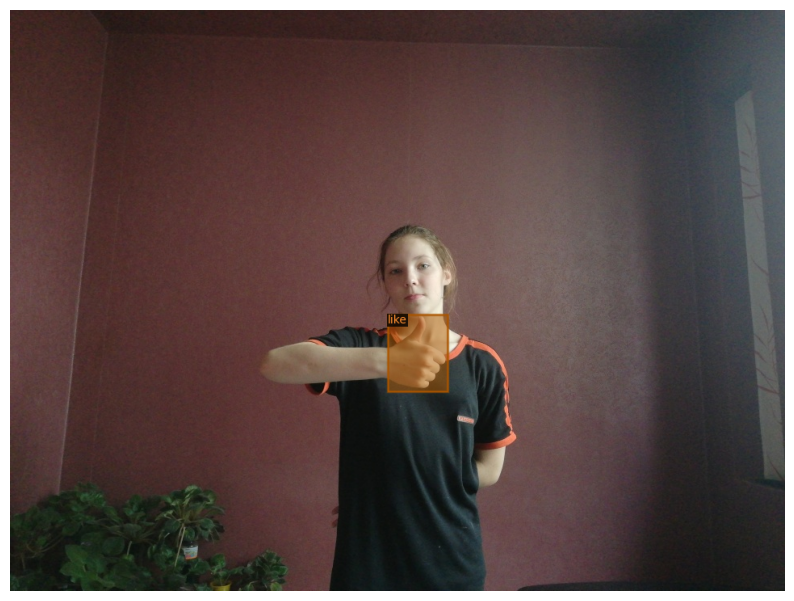

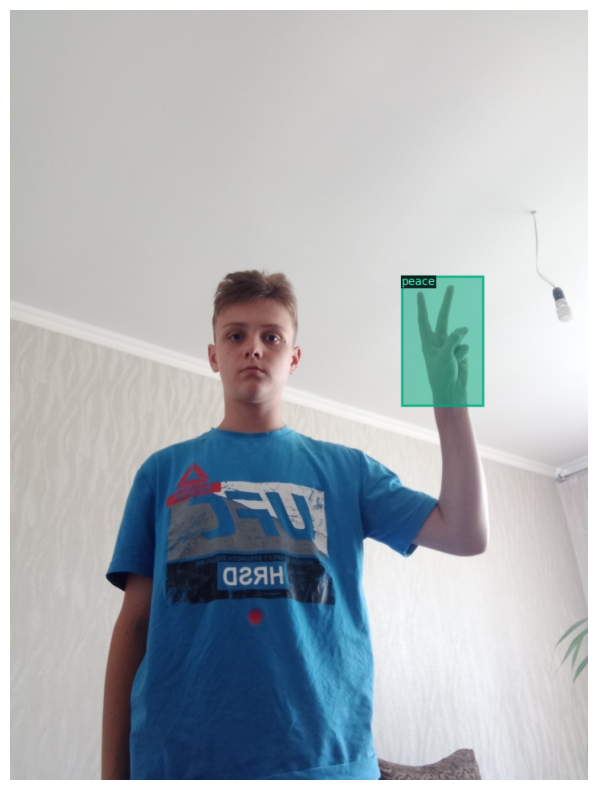

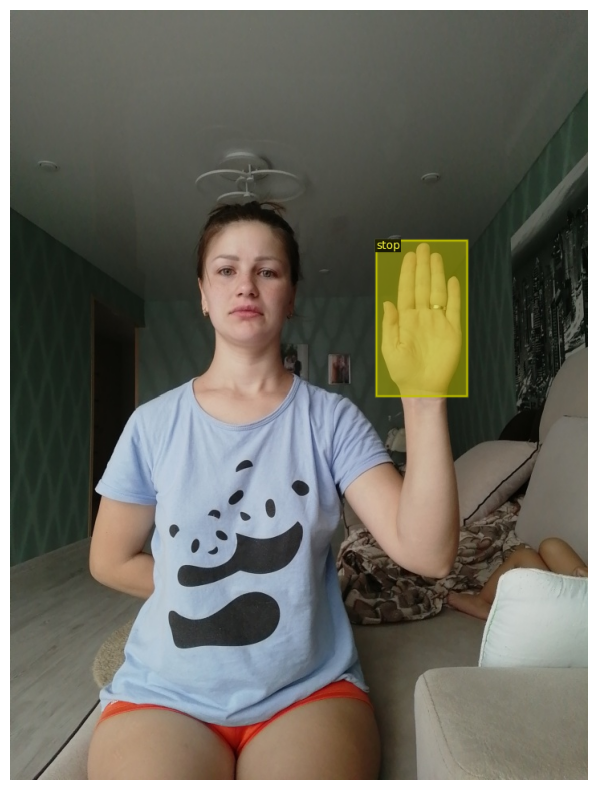

In [4]:
# visualize some data from training 
import random
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get('hagrid_train')
meta_dicts = MetadataCatalog.get('hagrid_train')

for item in random.sample(dataset_dicts, 3):
    img = cv2.imread(item['file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    annotated_image = Visualizer(img, metadata = meta_dicts, 
                                 scale = 1).draw_dataset_dict(item).get_image()
    
    plt.figure(figsize = [10,10])
    plt.imshow(annotated_image)
    plt.axis('off')
    

In [5]:
# prepare for training
from detectron2 import model_zoo
MAX_EPOCH = 16
STEP_EPOCH = 7
INIT_EPOCH = 5
NUM_IMAGES = len(dataset_dicts)

model_config_file = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'

cfg = get_cfg()
cfg.MODEL.DEVICE = 'cuda:1'
cfg.merge_from_file(model_zoo.get_config_file(model_config_file))

cfg.OUTPUT_DIR = './models'
cfg.DATASETS.TRAIN = ('hagrid_train',)
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config_file)
                                                 
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 2e-5
cfg.SOLVER.MAX_ITER = NUM_IMAGES * MAX_EPOCH 
cfg.SOLVER.STEPS = [e * NUM_IMAGES for e in range(INIT_EPOCH, MAX_EPOCH, STEP_EPOCH )]
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6


In [ ]:
# start training 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [35]:
# prepare for testing
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 
predictor = DefaultPredictor(cfg)

[04/23 00:22:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/model_final.pth ...


WARNING [04/23 00:22:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 00:22:31 d2.data.datasets.coco]: Loaded 600 images in COCO format from ./hagrid_coco_format/test.json


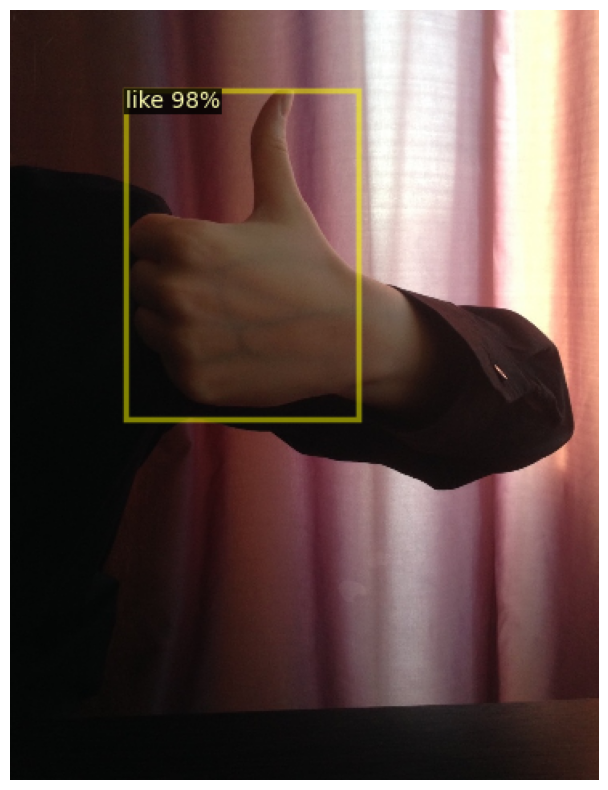

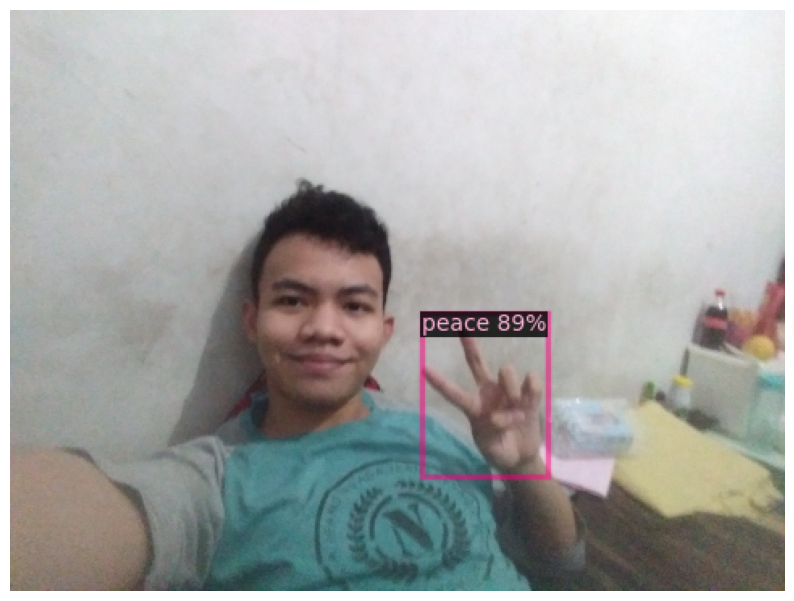

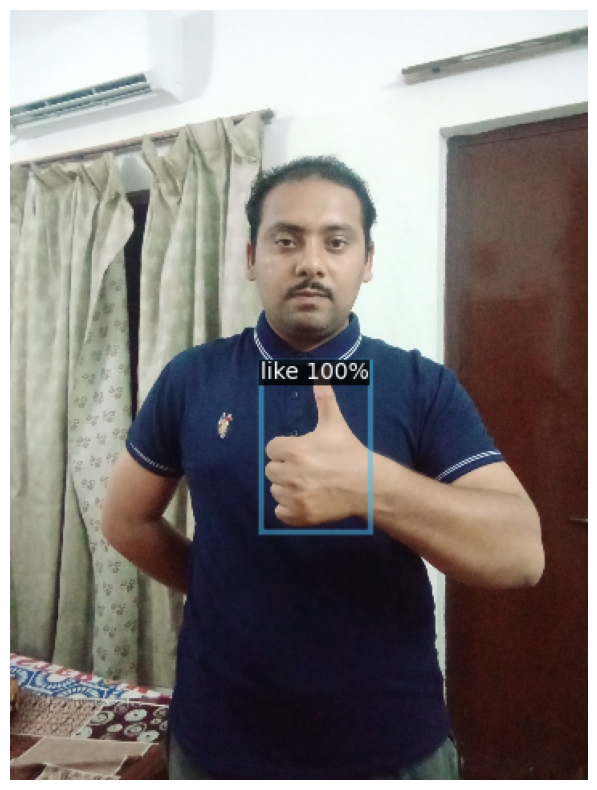

In [36]:
# see how it performs on test validation set
dataset_dicts = DatasetCatalog.get('hagrid_test')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1], metadata = meta_dicts, scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=[10,10])
    plt.imshow(out.get_image())
    plt.axis('off')

In [37]:
# evaluate the mAP
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("hagrid_test", output_dir="./evaluate")
val_loader = build_detection_test_loader(cfg, "hagrid_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [04/23 00:22:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 00:22:32 d2.data.datasets.coco]: Loaded 600 images in COCO format from ./hagrid_coco_format/test.json
[04/23 00:22:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 00:22:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/23 00:22:32 d2.data.common]: Serializing 600 elements to byte tensors and concatenating them all ...
[04/23 00:22:32 d2.data.common]: Serialized dataset takes 0.22 MiB
[04/23 00:22:32 d2.evaluation.evaluator]: Start inference on 600 batches
[04/23 00:22:32 d2.evaluation.evaluator]: Inference done 11/600. Dataloading: 0.0009 s/iter. Inference: 0.0317 s/iter. Eval: 0.0002 s/iter. Total: 0.0328 s/iter. ETA=0:00:19
[04/23 00:22:37 d2.evaluation.evaluat

In [43]:
dataset_dicts = DatasetCatalog.get('hagrid_test')
pred_class = []
gt_label = []
for d in dataset_dicts:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    pred_score = outputs['instances'].scores.detach().cpu().numpy()
    pred_classes = outputs['instances'].pred_classes.detach().cpu().numpy()
    items = sorted(zip(pred_score, pred_classes), reverse=True)
    if len(items):
        pred_class.append(items[0][1])
        gt_label.append(d['annotations'][0]['category_id'])

print(pred_class, gt_label)

WARNING [04/23 00:24:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 00:24:25 d2.data.datasets.coco]: Loaded 600 images in COCO format from ./hagrid_coco_format/test.json
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [44]:
ratio = len(pred_class) / len(dataset_dicts)
print('The ratio of images identified:{} {}/{}'.format(ratio, len(pred_class) , len(dataset_dicts)))

The ratio of images identified:0.9933333333333333 596/600


In [45]:
from sklearn.metrics import classification_report
print(classification_report(gt_label, pred_class))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        99
           1       0.98      0.96      0.97        99
           2       0.98      1.00      0.99       100
           3       0.97      0.99      0.98        99
           4       0.99      0.96      0.97        99
           5       0.98      0.99      0.99       100

    accuracy                           0.98       596
   macro avg       0.98      0.98      0.98       596
weighted avg       0.98      0.98      0.98       596



In [46]:
# evaluate the model using living camera to control computers, this will not be shown here in the note book